# Model Run: Pair learning
Version 1  
Low

Version 2  
Pregenerate list pair dataset

Version 3  
Using contrastive loss. 

## Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F


from model_model import SiameseNetworkV2
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import MelSpecTransform, DS_Tools
from model_dataset import PairRecDatasetPregen as ThisDataset
from model_loss import ContrastiveLoss, calculate_mean_ci
from model_filter import XpassFilter
from paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *

## Configure READ

In [2]:
READ = False

## Get Timestamp

In [3]:
if READ: 
    ts = "1113221926"
else: 
    ts = str(get_timestamp())
    ts = "1120221328"

train_name = "pair-low"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

pair-low-1120221328


In [4]:
stop_epoch = "99"
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
# save_valprec_name = "valprec.hst"
# save_valrec_name = "valrec.hst"
# save_valf_name = "valf.hst"
# val_same_name = "valsame.csv"
# val_diff_name = "valdiff.csv"

val_pos_name = "valpos.hst"
val_neg_name = "valneg.hst"

## Prepare Loss Recording

In [5]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

# valid_same = DfRecorder(os.path.join(model_save_dir, val_same_name))
# valid_diff = DfRecorder(os.path.join(model_save_dir, val_diff_name))
# valid_precs = ListRecorder(os.path.join(model_save_dir, save_valprec_name))
# valid_recs = ListRecorder(os.path.join(model_save_dir, save_valrec_name))
# valid_fs = ListRecorder(os.path.join(model_save_dir, save_valf_name))

valid_pos = ListRecorder(os.path.join(model_save_dir, val_pos_name))
valid_neg = ListRecorder(os.path.join(model_save_dir, val_neg_name))

## Prepare Dataset

In [7]:
mytrans = MelSpecTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
                            n_fft=TrainingConfigs.N_FFT, 
                            n_mels=TrainingConfigs.N_MELS, 
                            filter=XpassFilter(cut_off_upper=500))
ds = ThisDataset(train_cut_audio_, os.path.join(src_, "guide_mod.csv"), 
                 list_save_dir=model_save_dir, 
                 total_number=1000, transform=mytrans)

if not READ: 
    # use_len = int(0.01 * len(ds))
    # remain_len = len(ds) - use_len
    # use_ds, remain_ds = random_split(ds, [use_len, remain_len])
    use_ds = ds

    train_len = int(0.8 * len(use_ds))
    valid_len = len(use_ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(use_ds, [train_len, valid_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.data"), train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.data"), valid_ds.indices)
else: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.data"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.data"))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

train_loader = DataLoader(train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)
print(train_num, valid_num)

800 200


## Init Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# criterion = nn.MSELoss()
criterion = ContrastiveLoss(margin=1.5)
# NOTE: no need to mask the loss, because we don't do reconstruction. 

dimconf = ModelDimConfigs(
        rnn_in_size=TrainingConfigs.N_MELS, 
        lin_in_size_1=16, 
        lin_in_size_2=4, 
        lin_out_size_2=1
    )

model = SiameseNetworkV2(
    dimconf=dimconf
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [9]:
model

SiameseNetworkV2(
  (rnn): SelfPackLSTM(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (extract): LastElementExtractor()
  )
)

## Load Model if READ

In [10]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [11]:
EPOCHS = 30
BASE = 0

THRESHOLD = 0.3

In [12]:
def evaluate_pair(output1,output2,target,threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    # if target == 1:
    #     return euclidean_distance > threshold
    # else:
    #     return euclidean_distance <= threshold
    cond = euclidean_distance<threshold
    # print(cond)
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        if target[i]:
            neg_sum+=1
            if not cond[i]:
                neg_acc+=1
        if not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    return pos_acc,pos_sum,neg_acc,neg_sum


def draw_learning_curve_and_accuracy(losses, accs, epoch="", save=False, save_name=""): 
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    train_losses, valid_losses, best_val_loss = losses
    valid_pos, valid_neg = accs

    # Plot Loss on the left subplot
    ax1.plot(train_losses, label='Train')
    ax1.plot(valid_losses, label='Valid')
    ax1.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
    ax1.set_title("Learning Curve Loss" + f" {epoch}")
    ax1.legend(loc="upper right")

    # Plot Accuracy on the right subplot
    ax2.plot(valid_pos, label='Pos')
    ax2.plot(valid_neg, label='Neg')
    ax2.set_title('Learning Curve Accuracy' + f" {epoch}")
    ax2.legend(loc="lower right")

    # Display the plots
    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if save: 
        plt.savefig(save_name)

In [19]:
def train(): 
    best_valid_loss = 1e9
    best_valid_loss_epoch = 0
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, ((x_1, x_1_lens), (x_2, x_2_lens), y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            o1, o2 = model((x_1, x_2), (x_1_lens, x_2_lens))
            # y_hat = y_hat.squeeze(dim=1)
            loss = criterion(o1, o2, y)
            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        val_pos_accuracy = 0
        val_neg_accuracy = 0
        num_pos = 0
        num_neg = 0
        for idx, ((x_1, x_1_lens), (x_2, x_2_lens), y) in enumerate(valid_loader):
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            o1, o2 = model((x_1, x_2), (x_1_lens, x_2_lens))
            # y_hat = y_hat.squeeze(dim=1)
            loss = criterion(o1, o2, y)
            valid_loss += loss.item()

            pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(o1, o2, y, THRESHOLD)
            val_pos_accuracy+=pos_acc
            val_neg_accuracy+=neg_acc
            num_pos+=pos_sum
            num_neg+=neg_sum
            # euclidean_distance = F.pairwise_distance(o1, o2, keepdim = False)

            # pred = model.predict_on_output(o1, o2, threshold=THRESHOLD)

            # valid_preds += pred.cpu().tolist()
            # valid_targets += y.cpu().tolist()

            draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        val_pos_accuracy /= num_pos
        val_neg_accuracy /= num_neg

        valid_pos.append(val_pos_accuracy)
        valid_neg.append(val_neg_accuracy)
        
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         accs=(valid_pos.get(), valid_neg.get()),
                                         epoch=str(epoch))
        train_losses.save()
        valid_losses.save()
        valid_pos.save()
        valid_neg.save()
    
    return best_valid_loss_epoch

In [21]:
valid_pos.get(), valid_neg.get()

([0.8469387755102041,
  0.6938775510204082,
  0.45918367346938777,
  0.3163265306122449,
  0.22448979591836735,
  0.17346938775510204,
  0.1326530612244898,
  0.11224489795918367,
  0.05102040816326531,
  0.04081632653061224,
  0.04081632653061224,
  0.04081632653061224,
  0.030612244897959183,
  0.02040816326530612,
  0.02040816326530612,
  0.02040816326530612,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.01020408163265306,
  0.02040816326530612,
  0.02040816326530612,
  0.02040816326530612,
  0.02040816326530612,
  0.02040816326530612,
  0.02040816326530612],
 [0.10784313725490197,
  0.20588235294117646,
  0.4215686274509804,
  0.6078431372549019,
  0.7450980392156863,
  0.7941176470588235,
  0.8529411764705882,
  0.8921568627450981,
  0.9313725490196079,
  0.9509803921568627,
  0.9509803921568627,
  0.9607843137254902,


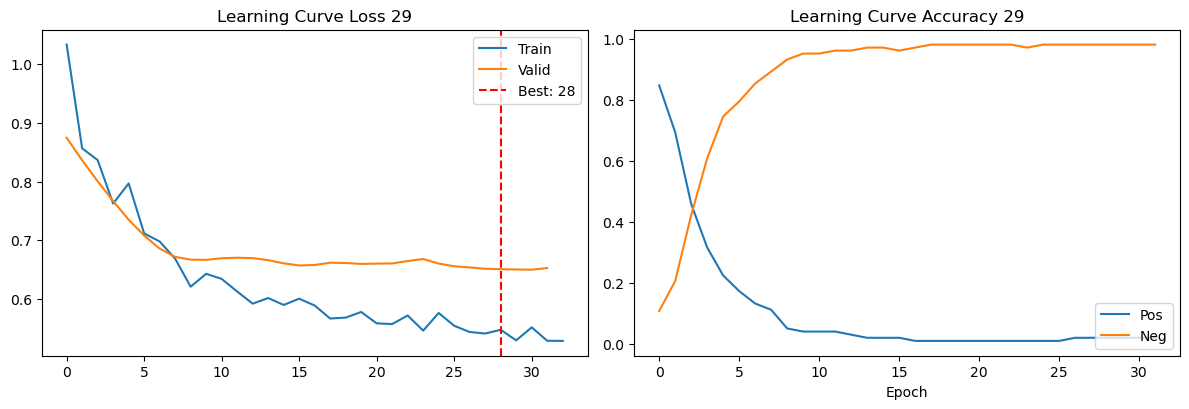

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

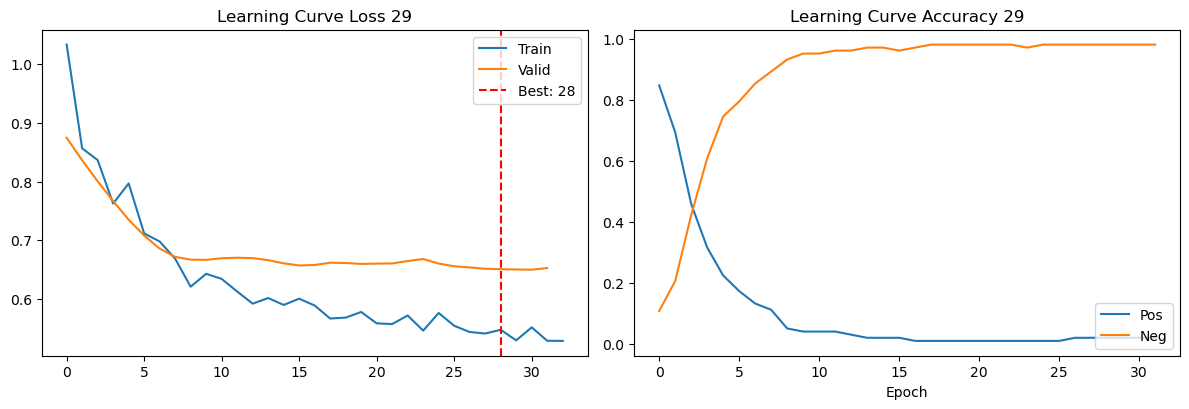

In [20]:
if __name__ == "__main__": 
    best_valid_loss_epoch = train()
    draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         accs=(valid_pos.get(), valid_neg.get()),
                                         epoch=str(BASE + EPOCHS - 1), 
                                         save=True,
                                         save_name=f"{model_save_dir}/vis.png")